Computer Vision (2023-2024) Project

**Weidong Cai 1836167**

**Elena Jiang 1846716**

# **Table of Contents**

1. Global Constants

2. Dependences

3. Human Animal Classification

    3.1.  Dataset 

    3.2.  Image Augmentation

    3.3.  Machine Learning
    
    3.4.  Model Evaluation

    3.5.  Save csv
  
4. Animal Emotion

    4.1.  Dataset 

    4.2.  Image Augmentation

    4.3.  Machine Learning
    
    4.4.  Model Evaluation

    4.5.  Save csv

  
5. Animal Emotion

    5.1.  Dataset 

    5.2.  Image Augmentation

    5.3.  Machine Learning
    
    5.4.  Model Evaluation

    5.5.  Save csv

  
6. Prediction


7. Prediction

# **Abstract**
The main goal of the project is to use using computer vision processing to distinguish between animals and humans. Additionally, it incorporates an emotion detection module, analyzing facial expressions to identify animal emotions accurately.

# **1. Global Constants**

In [8]:
emo_data_dir = 'emotion_dataset'
type_data_dir = 'animal_human_dataset'

huamn_train_path='/Users/jngelena/Desktop/computer_vision/project/fer-13/train'
human_test_path='/Users/jngelena/Desktop/computer_vision/project/fer-13/test'

RANDOM_SEED = 42

# **2. Dependences**

In [2]:
#import useful package
import os
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/jngelena/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model


# **3. Human Animal Classification**

## **3.1.** Dataset

### **3.1.1.** Analizing 

In [4]:
"""
This function generate a dictionary with path of an image and its label.
"""
def generate_data_paths(data_dir):    
    image_path_label = {}
    folds = os.listdir(data_dir)

    for fold in folds:
        if fold.startswith('.') or not os.path.isdir(os.path.join(data_dir, fold)):
            continue
            
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            image_path_label[fpath] = fold
            
    return image_path_label

In [5]:
"""
This function tells how many images contain in each folder.
"""
def classes_count(df, name= 'dataset'):
    print(f"The {name} has: ")
    for name in df['label'].unique():
        num_class = len(df['label'][df['label'] == name])
        print(f"Class '{name}' has {num_class} images")

In [6]:
image_path_label = generate_data_paths(type_data_dir)
df_type = pd.DataFrame(list(image_path_label.items()), columns=['path', 'label'])
display(df_type)

path  label
0                   animal_human_dataset/pet/63.jpg    pet
1             animal_human_dataset/pet/36 copia.jpg    pet
2                   animal_human_dataset/pet/77.jpg    pet
3     animal_human_dataset/pet/aug-62-081 copia.jpg    pet
4           animal_human_dataset/pet/aug-135-78.jpg    pet
...                                             ...    ...
2025         animal_human_dataset/human/1 (322).jpg  human
2026         animal_human_dataset/human/1 (772).jpg  human
2027         animal_human_dataset/human/1 (288).jpg  human
2028         animal_human_dataset/human/1 (119).png  human
2029          animal_human_dataset/human/1 (82).jpg  human

[2030 rows x 2 columns]

In [7]:
print(f"The Human and Pet dataset has {df_type.shape[0]} images divided in {len(df_type['label'].unique())} classes")

The Human and Pet dataset has 2030 images divided in 2 classes


In [8]:
classes_count(df_type, name='Human and Pet dataset')

The Human and Pet dataset has: 
Class 'pet' has 1001 images
Class 'human' has 1029 images


### **3.1.2.** Split Dataframe


In [5]:
def split_dataframe(df):
    train_df, dummy_df = train_test_split(df, train_size= 0.7, shuffle= True, random_state= RANDOM_SEED)
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.6, shuffle= True, random_state= RANDOM_SEED)
    return train_df, valid_df, test_df

In [7]:
train_df_type, valid_df_type, test_df_type = split_dataframe(df_type)

In [9]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

In [10]:
num_of_examples(train_df_type, 'Human and Pet Training')
num_of_examples(valid_df_type, 'Human and Pet Validation')
num_of_examples(test_df_type, 'Human and Pet Testing')

The Human and Pet Training dataset has 1421 images.
The Human and Pet Validation dataset has 365 images.
The Human and Pet Testing dataset has 244 images.


In [13]:
classes_count(train_df_type, 'training dataset')

The training dataset has: 
Class 'human' has 725 images
Class 'pet' has 696 images


## **3.2.** Image Augmentation

In [7]:
def plot_generator_images(data_generator, num_images=4):
    g_dict = data_generator.class_indices
    classes = list(g_dict.keys())
    images, labels = next(data_generator)
    
    plt.figure(figsize=(12, 12))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        
        if len(labels[i]) == 1:
            # For binary classification without one-hot encoding
            index = int(labels[i])
        else:
            # For binary classification with one-hot encoding or multi-class classification
            index = np.argmax(labels[i])
            
        class_name = classes[index]
        plt.title(class_name, fontsize=12)
        plt.axis('off')
    
    plt.show()

In [8]:
def plot_generator_images(data_generator, num_images=4):
    g_dict = data_generator.class_indices      # defines dictionary {'class': index}
    classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(data_generator)  
    
    plt.figure(figsize=(12, 12))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        if len(labels[i]) == 1:
            # For binary classification
            index = int(labels[i][0])  # Assuming labels are one-hot encoded
        else:
            # For multi-class classification
            index = np.argmax(labels[i])

        if index >= len(classes):
            # Ensure the index is within the range of available classes
            index = 0
            
        class_name = classes[index]   # get class of image
        plt.title(class_name, fontsize= 12)
        plt.axis('off')
    plt.show()    # get a batch size samples from the generator

In [9]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [10]:
def create_and_plot_data_generators(train_df, valid_df, test_df, batch_size=16, img_size=(224, 224), channels=3):
    # Calculate a recommended test batch size based on the length of the test dataset
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

    # Create ImageDataGenerator objects for training, validation, and testing with data augmentation settings
    img_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.4, 0.6],
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True
    )

    train_gen = img_gen.flow_from_dataframe(
        train_df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    valid_gen = img_gen.flow_from_dataframe(
        valid_df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    # Note: we will use a custom test_batch_size, and make shuffle=False
    test_gen = img_gen.flow_from_dataframe(
        test_df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=test_batch_size
    )

    # Plot images from the training generator
    print("Training Generator:")
    plot_generator_images(train_gen)

    # Plot images from the validation generator
    print("Validation Generator:")
    plot_generator_images(valid_gen)

    # Plot images from the test generator
    print("Test Generator:")
    plot_generator_images(test_gen)

    return train_gen, valid_gen, test_gen


Found 1419 validated image filenames belonging to 2 classes.


Found 365 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.


/Users/jngelena/Library/Python/3.9/lib/python/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Training Generator:


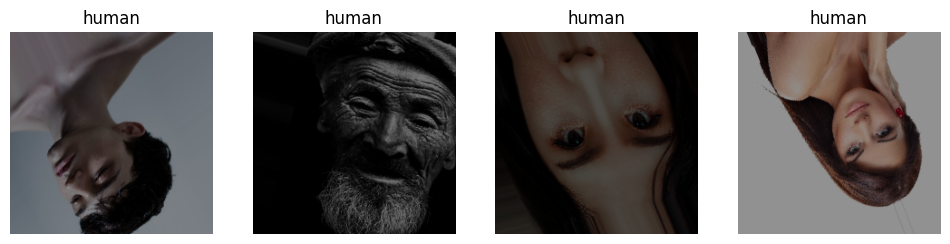

Validation Generator:


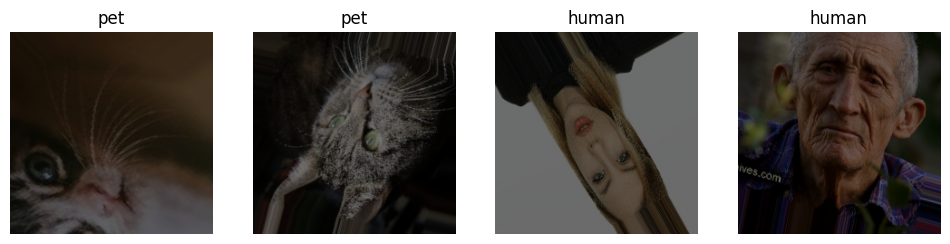

Test Generator:


/Users/jngelena/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


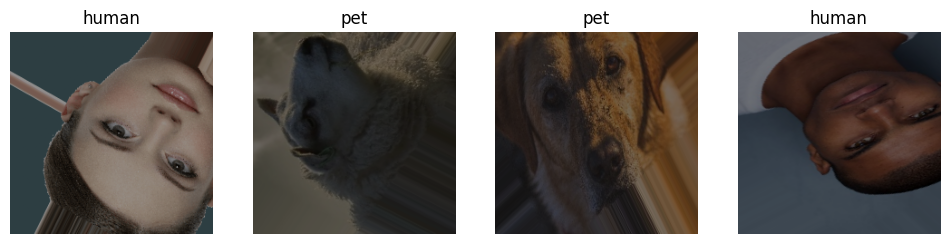

In [12]:
train_gen_type, valid_gen_type, test_gen_type = create_and_plot_data_generators(train_df_type, valid_df_type, test_df_type)

## **3.3.** Machine Learning

In [11]:
def create_efficientnet_model(img_size=(224, 224), channels=3, class_count=10):
    # Input shape
    img_shape = (img_size[0], img_size[1], channels)

    # Create pre-trained model (EfficientNetB5 in this case)
    base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
    base_model.trainable = False

    # Build the model
    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(256, activation='relu'),
        Dense(128, kernel_regularizer= regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu'),
        Dropout(rate=0.45, seed=RANDOM_SEED),
        Dense(class_count, activation='softmax')
    ])
    model.summary()

    # Set the training parameters
    model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

    return model

In [14]:
class_count_type = len(list(train_gen_type.class_indices.keys()))
model_type = create_efficientnet_model(class_count=class_count_type)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2

In [15]:
batch_size = 16   # set batch size for training
history_type = model_type.fit(x=train_gen_type,
                    epochs= 10,
                    verbose= 1,
                    validation_data= valid_gen_type, 
                    validation_steps= None,
                    shuffle= False)

Epoch 1/10
89/89 [==============================] - 76s 797ms/step - loss: 3.3127 - accuracy: 0.8302 - val_loss: 2.9370 - val_accuracy: 0.9726
Epoch 2/10
89/89 [==============================] - 70s 790ms/step - loss: 2.7489 - accuracy: 0.9479 - val_loss: 2.4953 - val_accuracy: 0.9808
Epoch 3/10
89/89 [==============================] - 72s 813ms/step - loss: 2.3778 - accuracy: 0.9641 - val_loss: 2.1404 - val_accuracy: 0.9945
Epoch 4/10
89/89 [==============================] - 74s 831ms/step - loss: 2.0506 - accuracy: 0.9690 - val_loss: 1.8362 - val_accuracy: 0.9945
Epoch 5/10
89/89 [==============================] - 74s 829ms/step - loss: 1.7302 - accuracy: 0.9838 - val_loss: 1.5482 - val_accuracy: 0.9973
Epoch 6/10
89/89 [==============================] - 72s 808ms/step - loss: 1.4655 - accuracy: 0.9810 - val_loss: 1.3000 - val_accuracy: 0.9945
Epoch 7/10
89/89 [==============================] - 74s 829ms/step - loss: 1.2378 - accuracy: 0.9873 - val_loss: 1.0860 - val_accuracy: 0.9973

In [20]:
def plot_training_history(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

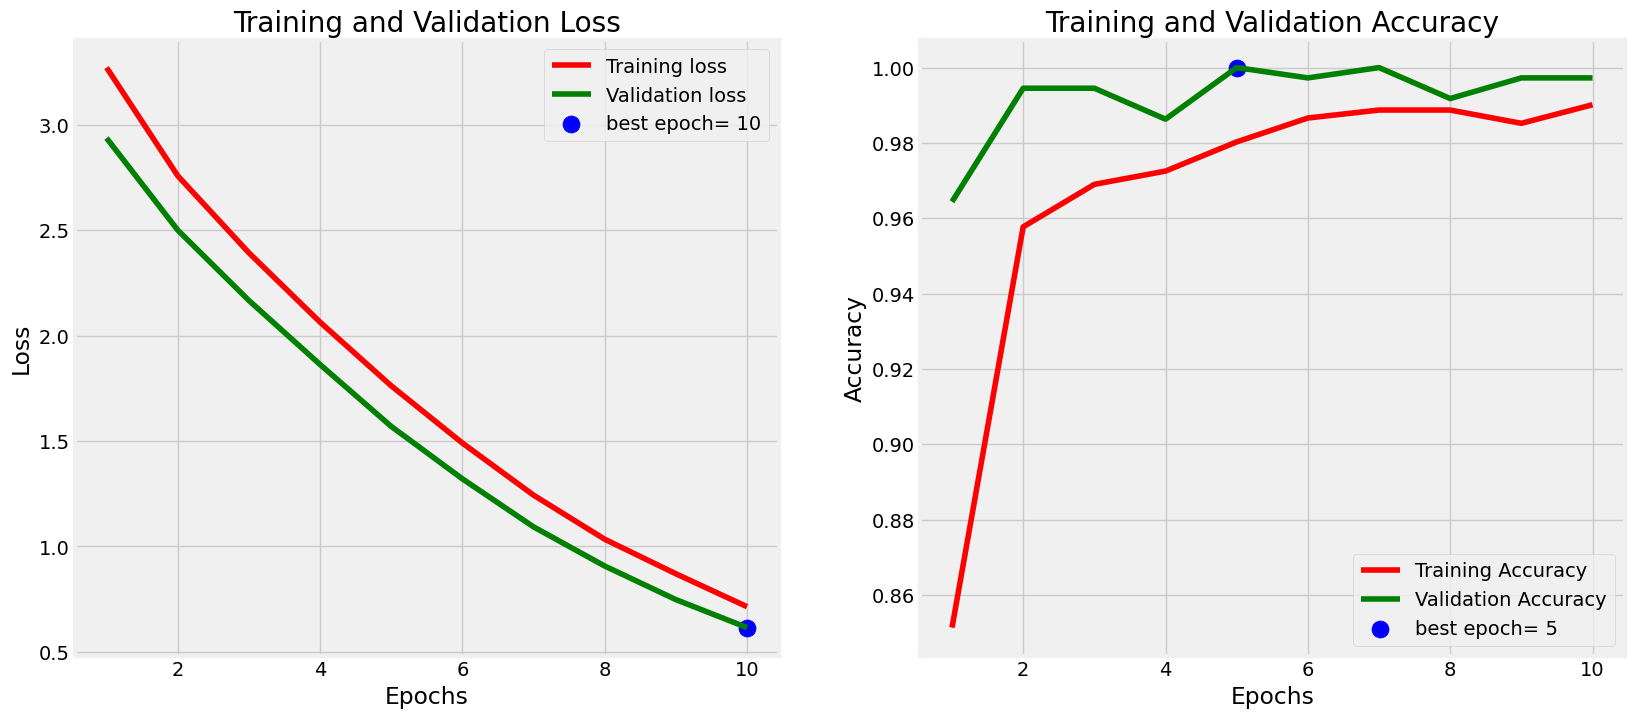

In [22]:
plot_training_history(history_type)

## **3.4.** Model Evaluation

In [17]:
def evaluate_model(model, test_df, train_gen, valid_gen, test_gen):
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

    print('Train Loss: ', train_score[0])
    print('Train Accuracy: ', train_score[1])
    print('-' * 20)
    print('Test Loss: ', test_score[0])
    print('Test Accuracy: ', test_score[1])

In [17]:
evaluate_model(model_type, test_df_type, train_gen_type, valid_gen_type, test_gen_type)

4/4 [==============================] - 10s 2s/step - loss: 0.6209 - accuracy: 0.9959
Train Loss:  0.6565356850624084
Train Accuracy:  0.96875
--------------------
Test Loss:  0.6208775639533997
Test Accuracy:  0.9959016442298889


In [18]:
preds_type = model_type.predict(test_gen_type)
y_pred_type = np.argmax(preds_type, axis=1)

4/4 [==============================] - 11s 2s/step


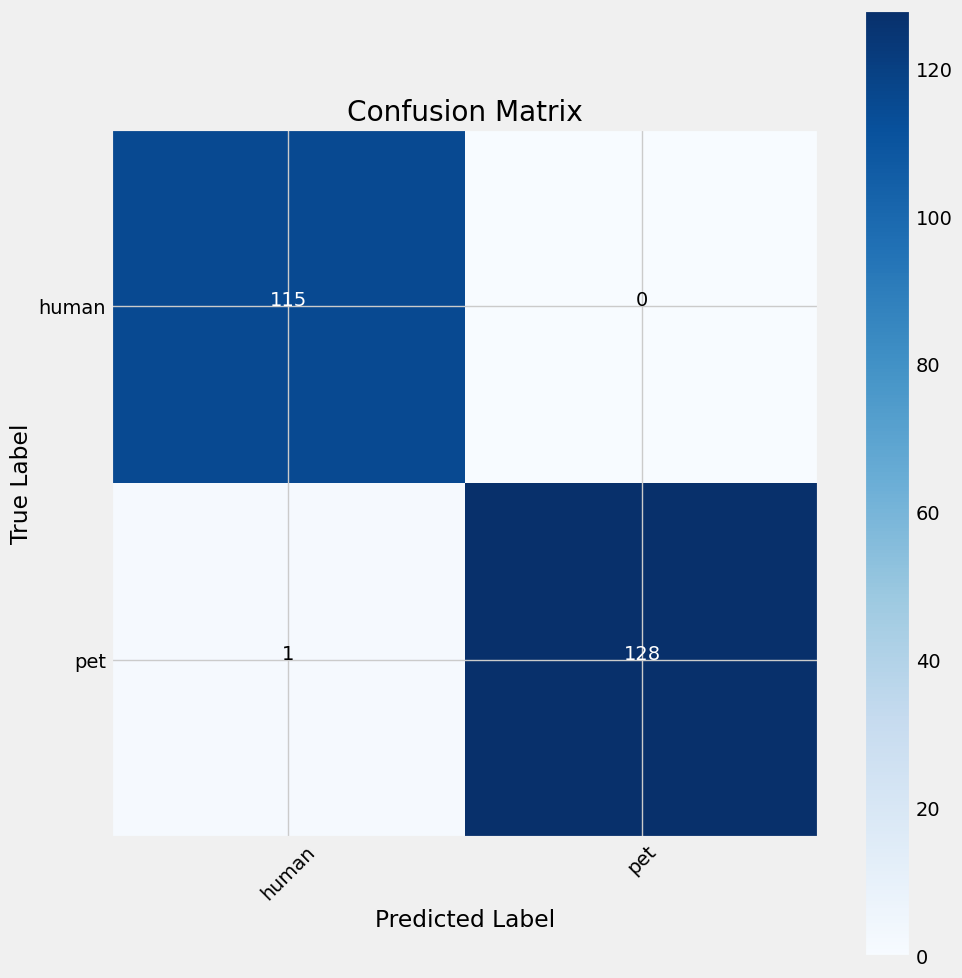

In [26]:
g_dict = test_gen_type.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen_type.classes, y_pred_type)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [27]:
# Classification report
print(classification_report(test_gen_type.classes, y_pred_type, target_names= classes))

              precision    recall  f1-score   support

       human       0.99      1.00      1.00       115
         pet       1.00      0.99      1.00       129

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



## **3.5.** Save Model

In [19]:
model_type.save('Animal_Human_model.h5')

#import pickle

#with open('Animal_Human_model.pkl', 'wb') as file:
#    pickle.dump(model_type, file)

/Users/jngelena/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **4. Animal Emotion**

## **4.1.** Dataset

### **4.1.1.** Analizing 

In [13]:
image_path_label = generate_data_paths(emo_data_dir)
df_emotion = pd.DataFrame(list(image_path_label.items()), columns=['path', 'label'])
display(df_emotion)

path  label
0     emotion_dataset/Happy/aug-70-085.jpg  Happy
1    emotion_dataset/Happy/aug-121-039.jpg  Happy
2     emotion_dataset/Happy/aug-78-097.jpg  Happy
3     emotion_dataset/Happy/aug-68-083.jpg  Happy
4      emotion_dataset/Happy/aug-8-012.jpg  Happy
..                                     ...    ...
995    emotion_dataset/Angry/aug-10-17.jpg  Angry
996           emotion_dataset/Angry/91.jpg  Angry
997           emotion_dataset/Angry/85.jpg  Angry
998           emotion_dataset/Angry/52.jpg  Angry
999           emotion_dataset/Angry/46.jpg  Angry

[1000 rows x 2 columns]

In [56]:
print(f"The Pet's emotion dataset has {df_emotion.shape[0]} images divided in {len(df_emotion['label'].unique())} classes")

The Pet emotion dataset has 1000 images divided in 4 classes


In [57]:
classes_count(df_emotion, name="Pet's emotion")

The Pet's emotion has: 
Class 'Happy' has 250 images
Class 'Sad' has 250 images
Class 'Other' has 250 images
Class 'Angry' has 250 images


### **4.1.2.** Split Dataframe


In [14]:
train_df_emo, valid_df_emo, test_df_emo = split_dataframe(df_emotion)

In [59]:
num_of_examples(train_df_emo, "Pet's emotion Training")
num_of_examples(valid_df_emo, "Pet's emotion Validation")
num_of_examples(test_df_emo, "Pet's emotion Testing")

The Pet's emotion Training dataset has 700 images.
The Pet's emotion Validation dataset has 180 images.
The Pet's emotion Testing dataset has 120 images.


In [34]:
classes_count(train_df_emo, 'training dataset')

The training dataset has: 
Class 'Other' has 175 images
Class 'Sad' has 172 images
Class 'Angry' has 175 images
Class 'Happy' has 178 images


## **4.2.** Image Augmentation

Found 700 validated image filenames belonging to 4 classes.
Found 180 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Training Generator:


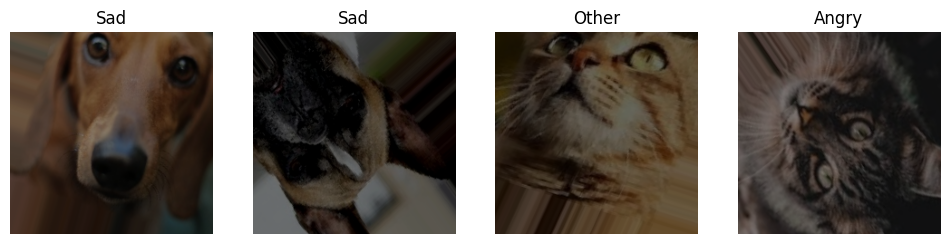

Validation Generator:


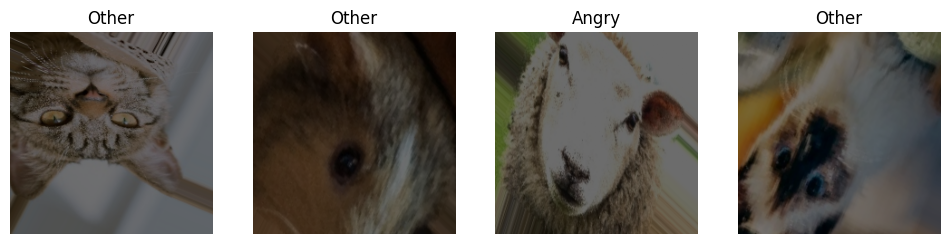

Test Generator:


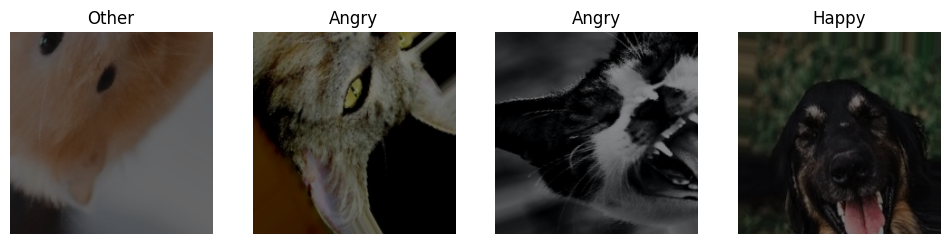

In [15]:
train_gen_emo, valid_gen_emo, test_gen_emo = create_and_plot_data_generators(train_df_emo, valid_df_emo, test_df_emo)

## **4.3.** Machine Learning

In [16]:
class_count_type = len(list(train_gen_emo.class_indices.keys()))
model_emo = create_efficientnet_model(class_count=class_count_type)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 5

In [18]:
batch_size = 16   # set batch size for training
history_emo = model_emo.fit(x=train_gen_emo,
                    epochs= 10,
                    verbose= 1,
                    validation_data= valid_gen_emo, 
                    validation_steps= None,
                    shuffle= False)

Epoch 1/10
44/44 [==============================] - 36s 747ms/step - loss: 4.5891 - accuracy: 0.3471 - val_loss: 4.5734 - val_accuracy: 0.3944
Epoch 2/10
44/44 [==============================] - 30s 690ms/step - loss: 4.3100 - accuracy: 0.3771 - val_loss: 4.1319 - val_accuracy: 0.4889
Epoch 3/10
44/44 [==============================] - 30s 680ms/step - loss: 4.1090 - accuracy: 0.4443 - val_loss: 3.9873 - val_accuracy: 0.4167
Epoch 4/10
44/44 [==============================] - 30s 679ms/step - loss: 3.9592 - accuracy: 0.4800 - val_loss: 3.7208 - val_accuracy: 0.5500
Epoch 5/10
44/44 [==============================] - 30s 679ms/step - loss: 3.7809 - accuracy: 0.5143 - val_loss: 3.6276 - val_accuracy: 0.5722
Epoch 6/10
44/44 [==============================] - 31s 705ms/step - loss: 3.6992 - accuracy: 0.5171 - val_loss: 3.5661 - val_accuracy: 0.5722
Epoch 7/10
44/44 [==============================] - 30s 691ms/step - loss: 3.5825 - accuracy: 0.5357 - val_loss: 3.4358 - val_accuracy: 0.5722

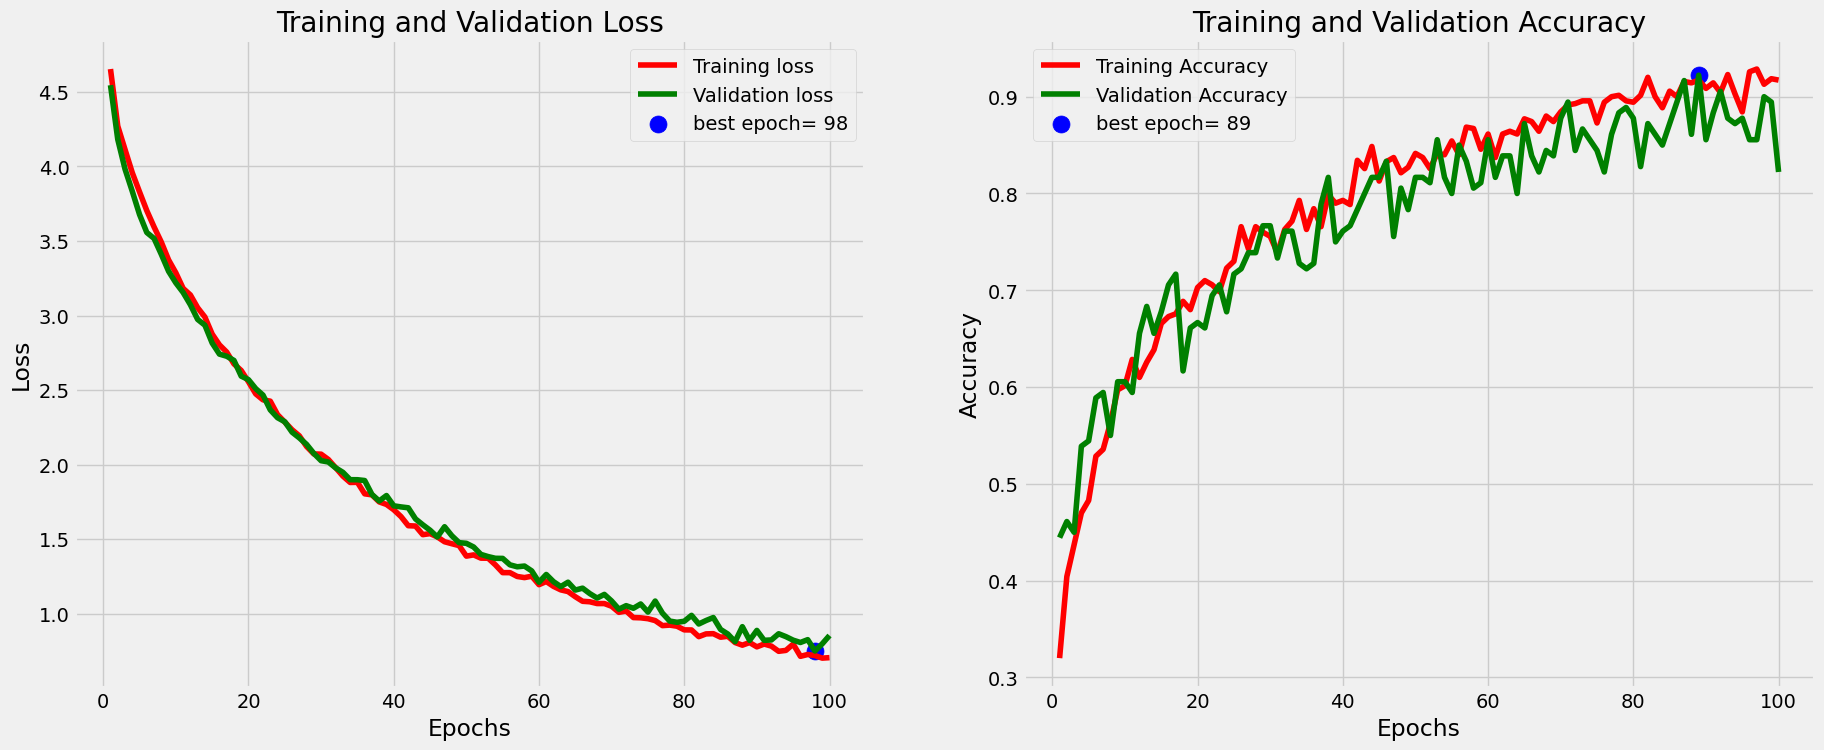

In [38]:
plot_training_history(history_emo)

## **4.4.** Model Evaluation

In [19]:
evaluate_model(model_emo, test_df_emo, train_gen_emo, valid_gen_emo, test_gen_emo)

2/2 [==============================] - 4s 2s/step - loss: 3.1775 - accuracy: 0.6333
Train Loss:  2.969156265258789
Train Accuracy:  0.78125
--------------------
Test Loss:  3.1774704456329346
Test Accuracy:  0.6333333253860474


In [20]:
preds_emo = model_emo.predict(test_gen_emo)
y_pred_emo = np.argmax(preds_emo, axis=1)

2/2 [==============================] - 6s 2s/step


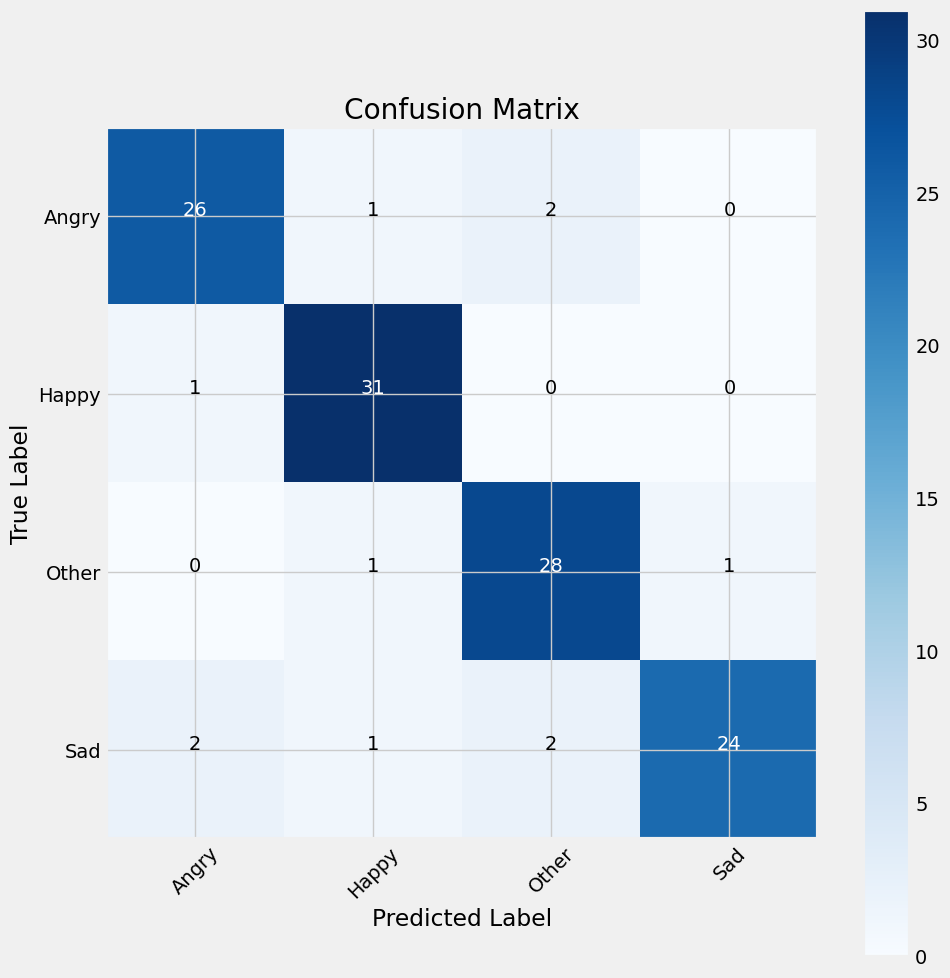

In [ ]:
g_dict = test_gen_emo.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen_emo.classes, y_pred_emo)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [42]:
print(classification_report(test_gen_emo.classes, y_pred_emo, target_names= classes))

              precision    recall  f1-score   support

       Angry       0.90      0.90      0.90        29
       Happy       0.91      0.97      0.94        32
       Other       0.88      0.93      0.90        30
         Sad       0.96      0.83      0.89        29

    accuracy                           0.91       120
   macro avg       0.91      0.91      0.91       120
weighted avg       0.91      0.91      0.91       120



## **4.5.** Save Model

In [21]:
model_emo.save('/Users/jngelena/Desktop/computer_vision/project/Animal_emotion_model.h5')

#with open('Animal_emotion_model.pkl', 'wb') as file:
#    pickle.dump(model_emo, file)

/Users/jngelena/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **5.** Human Emotion

## **5.1.** Dataset
### **5.1.1.** Analizing 

In [9]:
image_path_label = generate_data_paths(huamn_train_path)
df_train_human_emo = pd.DataFrame(list(image_path_label.items()), columns=['path', 'label'])
display(df_train_human_emo)

path    label
0      /Users/jngelena/Desktop/computer_vision/projec...    happy
1      /Users/jngelena/Desktop/computer_vision/projec...    happy
2      /Users/jngelena/Desktop/computer_vision/projec...    happy
3      /Users/jngelena/Desktop/computer_vision/projec...    happy
4      /Users/jngelena/Desktop/computer_vision/projec...    happy
...                                                  ...      ...
28704  /Users/jngelena/Desktop/computer_vision/projec...  disgust
28705  /Users/jngelena/Desktop/computer_vision/projec...  disgust
28706  /Users/jngelena/Desktop/computer_vision/projec...  disgust
28707  /Users/jngelena/Desktop/computer_vision/projec...  disgust
28708  /Users/jngelena/Desktop/computer_vision/projec...  disgust

[28709 rows x 2 columns]

In [33]:
print(f"The Human Emotion train dataset has {df_train_human_emo.shape[0]} images divided in {len(df_train_human_emo['label'].unique())} classes")

The Human Emotion train dataset has 28709 images divided in 7 classes


In [34]:
classes_count(df_train_human_emo, name='Human Emotion train dataset')

The Human Emotion train dataset has: 
Class 'happy' has 7215 images
Class 'sad' has 4830 images
Class 'fear' has 4097 images
Class 'surprise' has 3171 images
Class 'neutral' has 4965 images
Class 'angry' has 3995 images
Class 'disgust' has 436 images


In [10]:
image_path_label = generate_data_paths(human_test_path)
df_test_human_emo = pd.DataFrame(list(image_path_label.items()), columns=['path', 'label'])
display(df_test_human_emo)

path    label
0     /Users/jngelena/Desktop/computer_vision/projec...    happy
1     /Users/jngelena/Desktop/computer_vision/projec...    happy
2     /Users/jngelena/Desktop/computer_vision/projec...    happy
3     /Users/jngelena/Desktop/computer_vision/projec...    happy
4     /Users/jngelena/Desktop/computer_vision/projec...    happy
...                                                 ...      ...
7173  /Users/jngelena/Desktop/computer_vision/projec...  disgust
7174  /Users/jngelena/Desktop/computer_vision/projec...  disgust
7175  /Users/jngelena/Desktop/computer_vision/projec...  disgust
7176  /Users/jngelena/Desktop/computer_vision/projec...  disgust
7177  /Users/jngelena/Desktop/computer_vision/projec...  disgust

[7178 rows x 2 columns]

In [12]:
print(f"The Human Emotion test dataset has {df_test_human_emo.shape[0]} images divided in {len(df_test_human_emo['label'].unique())} classes")

The Human Emotion test dataset has 7178 images divided in 7 classes


In [13]:
classes_count(df_test_human_emo, name='Human Emotion test dataset')

The Human Emotion test dataset has: 
Class 'happy' has 1774 images
Class 'sad' has 1247 images
Class 'fear' has 1024 images
Class 'surprise' has 831 images
Class 'neutral' has 1233 images
Class 'angry' has 958 images
Class 'disgust' has 111 images


### **5.1.2.** Split Dataframe 

In [11]:
df_valid_human_emo, df_test_f_human_emo = train_test_split(df_test_human_emo, train_size= 0.6, shuffle= True, random_state= RANDOM_SEED)

## **5.2.** Image Augmentation

In [12]:
img_size = 48
batch_size = 64

datagen = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen.flow_from_dataframe(df_train_human_emo,
                                              x_col='path',
                                              y_col='label',
                                              target_size=(img_size,img_size),
                                              class_mode='categorical',
                                              color_mode="grayscale",     
                                              shuffle=True,
                                              batch_size=batch_size
                                              )

valid_generator = datagen.flow_from_dataframe(df_valid_human_emo, 
                                                   x_col='path',
                                                   y_col='label',
                                                   target_size=(img_size,img_size),
                                                   class_mode='categorical',
                                                   color_mode="grayscale",
                                                   shuffle=True,
                                                   batch_size=batch_size
                                                   )

test_generator = datagen.flow_from_dataframe(df_test_f_human_emo, 
                                                   x_col='path',
                                                   y_col='label',
                                                   target_size=(img_size,img_size),
                                                   class_mode='categorical',
                                                   color_mode="grayscale",
                                                   shuffle=False,
                                                   batch_size=batch_size
                                                   )

Found 28709 validated image filenames belonging to 7 classes.
Found 4306 validated image filenames belonging to 7 classes.
Found 2872 validated image filenames belonging to 7 classes.


Training Generator:


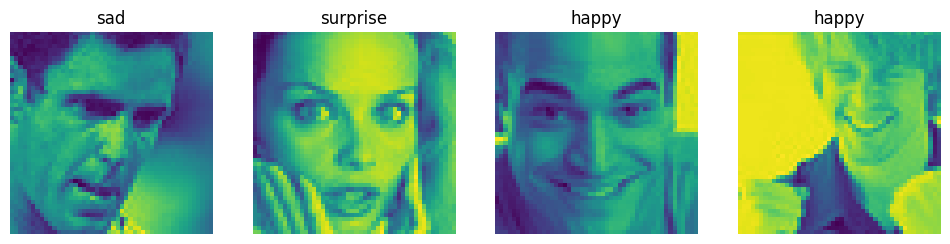

Validation Generator:


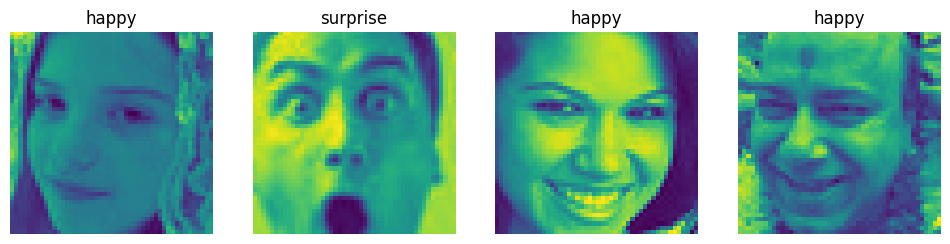

Test Generator:


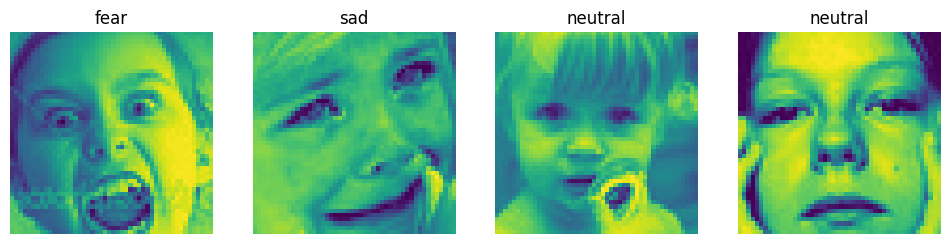

In [16]:
print("Training Generator:")
plot_generator_images(train_generator)

print("Validation Generator:")
plot_generator_images(valid_generator)

print("Test Generator:")
plot_generator_images(test_generator)

## **5.3.** Machine Learning

In [13]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer= Adam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

/Users/jngelena/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = valid_generator.n//valid_generator.batch_size

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data = valid_generator,
    validation_steps = validation_steps,
)

Epoch 1/5
448/448 [==============================] - 202s 450ms/step - loss: 2.0306 - accuracy: 0.2673 - val_loss: 1.6532 - val_accuracy: 0.3563
Epoch 2/5
448/448 [==============================] - 210s 468ms/step - loss: 1.6028 - accuracy: 0.3983 - val_loss: 1.4731 - val_accuracy: 0.4473
Epoch 3/5
448/448 [==============================] - 207s 462ms/step - loss: 1.3931 - accuracy: 0.4755 - val_loss: 1.4399 - val_accuracy: 0.4711
Epoch 4/5
448/448 [==============================] - 208s 464ms/step - loss: 1.2646 - accuracy: 0.5152 - val_loss: 1.2587 - val_accuracy: 0.5222
Epoch 5/5
448/448 [==============================] - 214s 478ms/step - loss: 1.1983 - accuracy: 0.5418 - val_loss: 1.2269 - val_accuracy: 0.5329


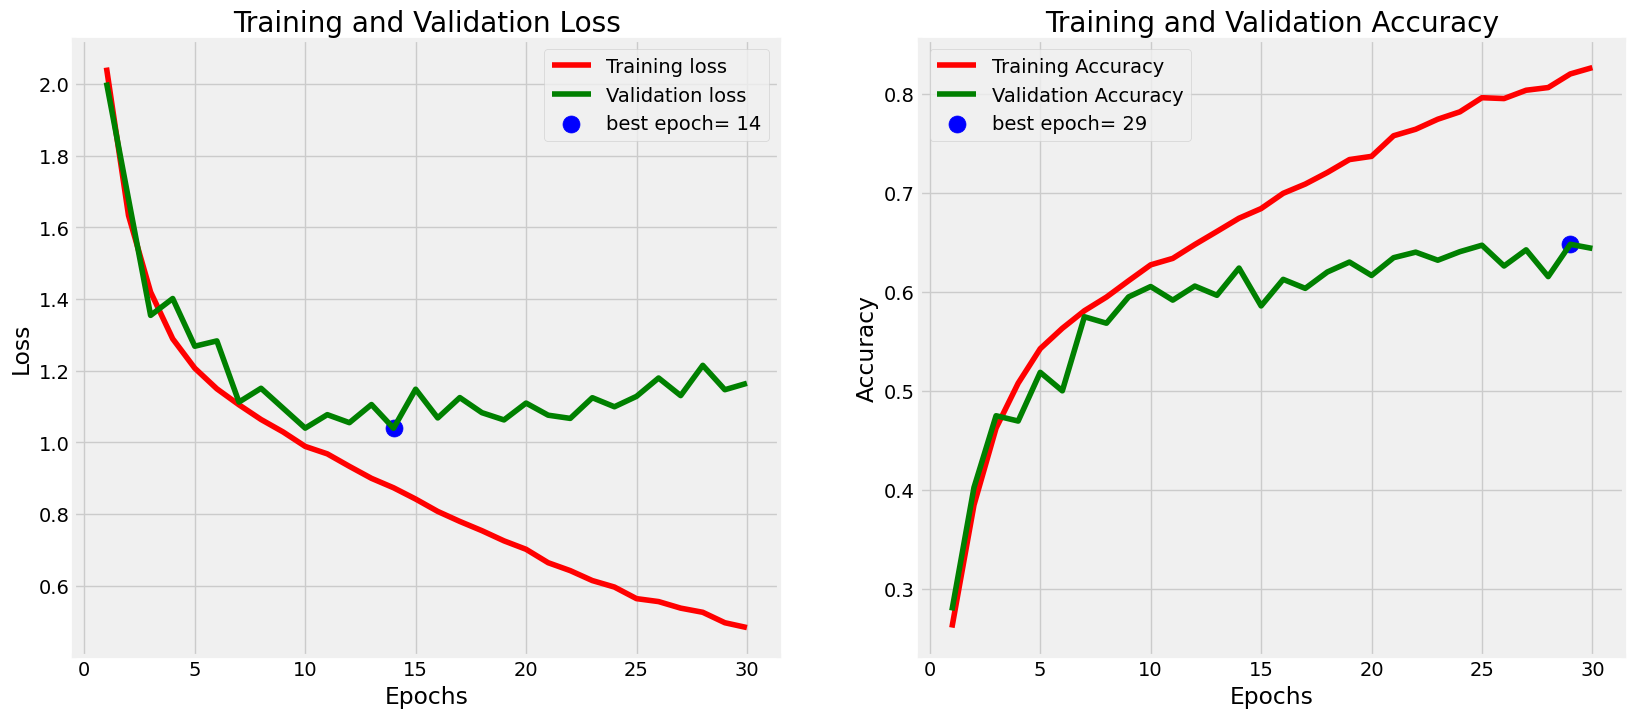

In [21]:
plot_training_history(history)

## **5.4.** Model Evaluation

In [18]:
evaluate_model(model, df_test_f_human_emo, train_generator, valid_generator, test_generator)

359/359 [==============================] - 5s 13ms/step - loss: 1.1951 - accuracy: 0.5554
Train Loss:  1.1261615753173828
Train Accuracy:  0.5711612105369568
--------------------
Test Loss:  1.1950701475143433
Test Accuracy:  0.5553621053695679


In [19]:
preds_emo = model.predict(test_generator)
y_pred_emo = np.argmax(preds_emo, axis=1)

45/45 [==============================] - 5s 103ms/step


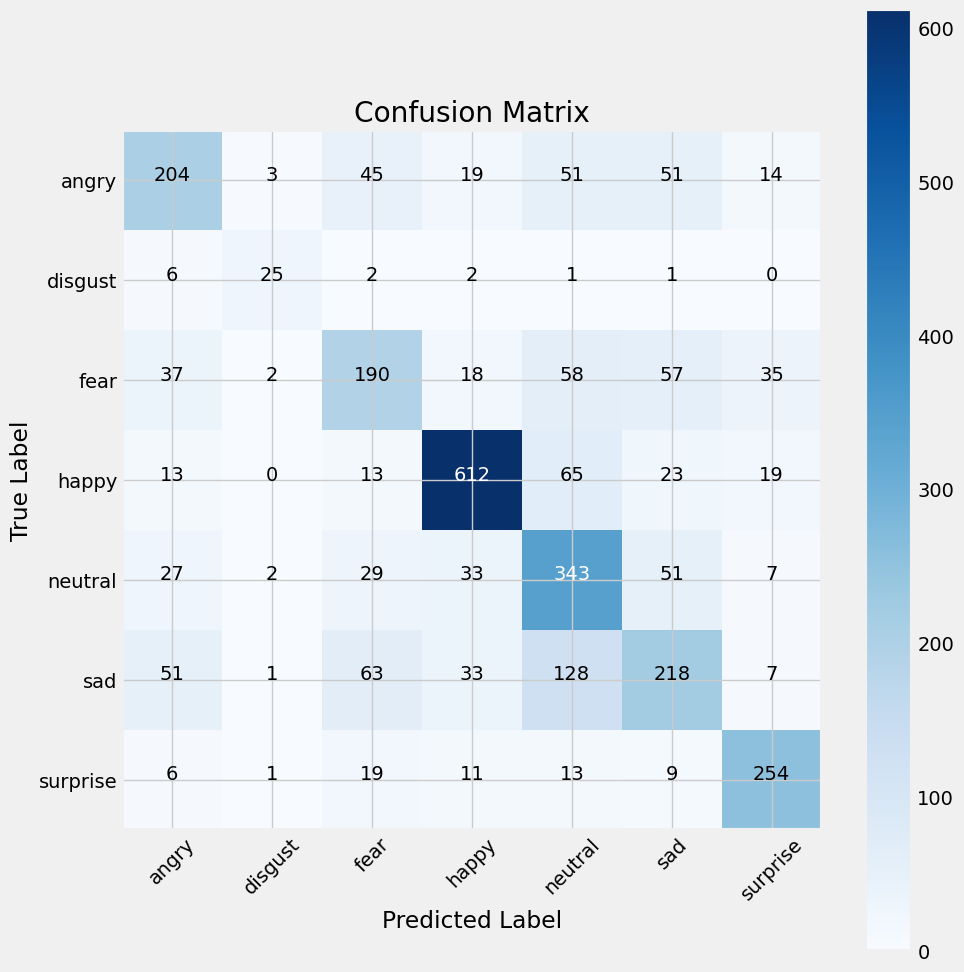

In [26]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred_emo)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [27]:
print(classification_report(test_generator.classes, y_pred_emo, target_names= classes))

              precision    recall  f1-score   support

       angry       0.59      0.53      0.56       387
     disgust       0.74      0.68      0.70        37
        fear       0.53      0.48      0.50       397
       happy       0.84      0.82      0.83       745
     neutral       0.52      0.70      0.60       492
         sad       0.53      0.44      0.48       501
    surprise       0.76      0.81      0.78       313

    accuracy                           0.64      2872
   macro avg       0.64      0.64      0.64      2872
weighted avg       0.64      0.64      0.64      2872



## **5.5.** Save Model

In [20]:
#import pickle

model.save('Human_emotion_model.h5')

#with open('Animal_emotion_model.pkl', 'wb') as file:
#    pickle.dump(model, file)

/Users/jngelena/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **6.** Prediction

1/1 [==============================] - 1s 1s/step


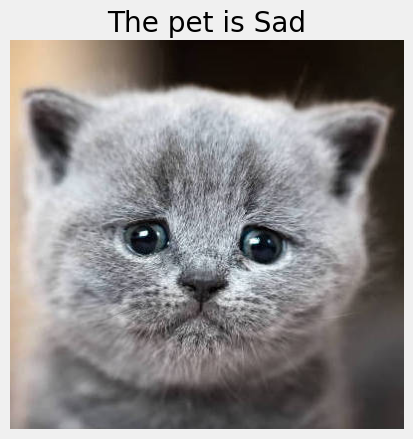

In [73]:
from PIL import Image

def predict_pet_or_human(image_path, pet_model, emotion_model, human_model):
    # Load the image and preprocess it
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Use Animal_Human_model to predict whether it's a pet or human
    pet_prediction = pet_model.predict(img_array)
    is_pet = pet_prediction[0][0] < 0.5  # Adjust the threshold as needed

    if is_pet:
        # If it's a pet, use Pets_Facial_Expression_model to predict emotion
        emotion_prediction = emotion_model.predict(img_array)
        emotion_class_index = np.argmax(emotion_prediction)
        class_labels = ['Angry', 'Happy', 'Other', 'Sad']
        emotion_label = class_labels[emotion_class_index]

        plt.imshow(image.load_img(image_path))
        plt.axis('off')
        plt.title(f"The pet is {emotion_label}")
        plt.show()
    else:
        # Convert the image to grayscale
        img = Image.open(image_path).convert('L')
        img = img.resize((48, 48))
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array[:, :, :, np.newaxis]  # Add a channel dimension
        img_array = preprocess_input(img_array)

        # If it's a human, you can add your logic here
        human_emotion_prediction = human_model.predict(img_array)
        human_emotion_class_index = np.argmax(human_emotion_prediction)
        class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        human_emotion_label = class_labels[human_emotion_class_index]

        plt.imshow(image.load_img(image_path))
        plt.axis('off')
        plt.title(f"The human is {human_emotion_label}")
        plt.show()

# Load Animal_Human_model and Pets_Facial_Expression_model
animal_human_model = load_model('Animal_Human_model.h5')
pets_emotion_model = load_model('Animal_emotion_model.h5')
human_emotion_model = load_model('Human_emotion_model.h5')

# Replace 'path_to_test_image' with the path to the image you want to test
predict_pet_or_human('animal.jpg', animal_human_model, pets_emotion_model, human_emotion_model)


1/1 [==============================] - 0s 15ms/step


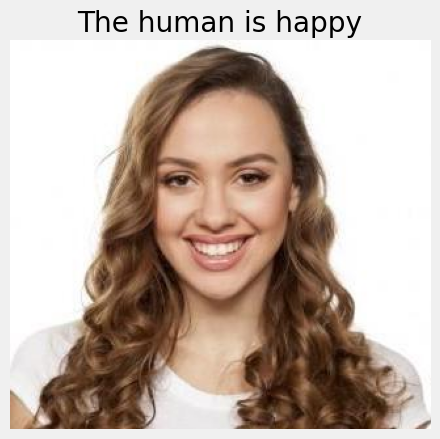

In [75]:
predict_pet_or_human('human1.jpeg', animal_human_model, pets_emotion_model, human_emotion_model)

1/1 [==============================] - 0s 14ms/step


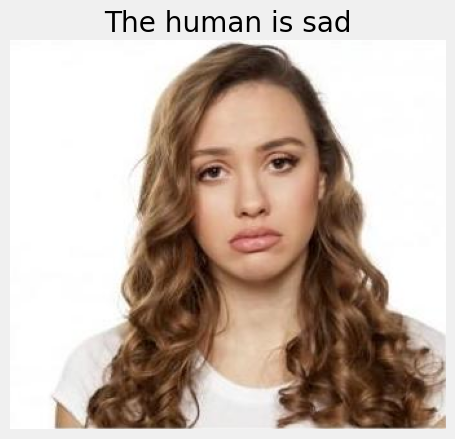

In [84]:
predict_pet_or_human('human2.jpg', animal_human_model, pets_emotion_model, human_emotion_model)

1/1 [==============================] - 0s 16ms/step


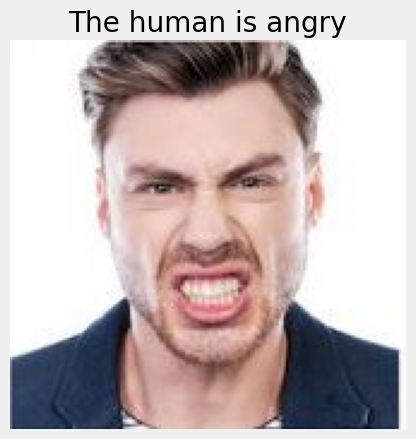

In [85]:
predict_pet_or_human('human3.jpg', animal_human_model, pets_emotion_model, human_emotion_model)

1/1 [==============================] - 0s 74ms/step


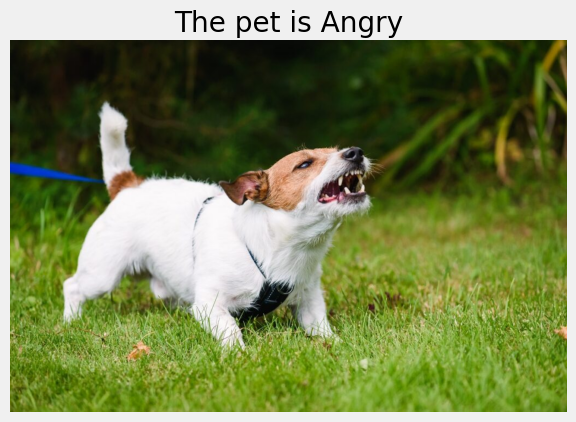

In [91]:
predict_pet_or_human('animal2.jpg', animal_human_model, pets_emotion_model, human_emotion_model)

1/1 [==============================] - 0s 78ms/step


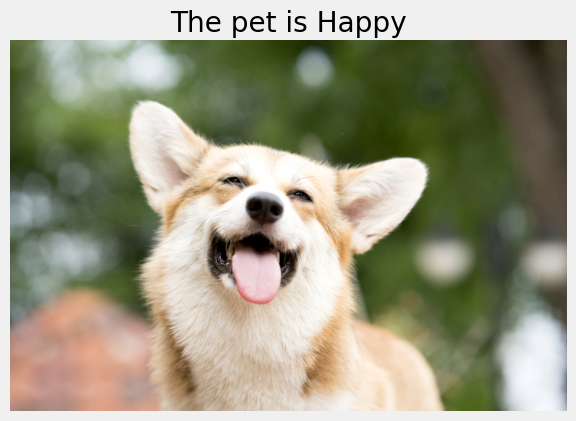

In [89]:
predict_pet_or_human('animal3.jpeg', animal_human_model, pets_emotion_model, human_emotion_model)

# **7.** Streamlit


In [3]:
%%writefile app.py
import streamlit as st
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load models
pet_model = load_model('Animal_Human_model.h5')
emotion_model = load_model('Animal_emotion_model.h5')
human_model = load_model('Human_emotion_model.h5')

# Preprocessing for pet models (RGB images)
def preprocess_pet_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array) 

# Preprocessing for human model (Grayscale images)
def preprocess_human_image(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((48, 48))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array[:, :, :, np.newaxis]
    return preprocess_input(img_array)

def main():
    st.title("Pet or Human Emotion Detection")

    image_path = st.file_uploader("Choose an image...", type=['png', 'jpg', 'jpeg'])
    if st.button("Submit") and image_path is not None:
        # Use different preprocessing based on model type
        pet_img_array = preprocess_pet_image(image_path)
        human_img_array = preprocess_human_image(image_path)

        # Pet or human prediction
        pet_prediction = pet_model.predict(pet_img_array)
        is_pet = pet_prediction[0][0] < 0.5

        if is_pet:
            # Pet emotion prediction
            emotion_prediction = emotion_model.predict(pet_img_array)
            emotion_class_index = np.argmax(emotion_prediction)
            class_labels = ['Angry', 'Happy', 'Other', 'Sad']
            emotion_label = class_labels[emotion_class_index]

            st.image(Image.open(image_path), caption=f"The pet is {emotion_label}", use_column_width=True)
        else:
            # Human emotion prediction
            human_emotion_prediction = human_model.predict(human_img_array)
            human_emotion_class_index = np.argmax(human_emotion_prediction)
            class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
            human_emotion_label = class_labels[human_emotion_class_index]

            st.image(Image.open(image_path), caption=f"The human is {human_emotion_label}", use_column_width=True)

if __name__ == "__main__":
    main()


Overwriting app.py


In [ ]:
!streamlit run app.py --server.maxMessageSize=2500